## Analysis on Focal Mechanisms of SLIQs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import os
import importlib

# stdlib imports
from datetime import datetime, timedelta

# Third party imports
import matplotlib.pyplot as plt

# Local imports
from libcomcat.search import count, get_event_by_id, search
from libcomcat.dataframes import get_detail_data_frame

In [2]:
catalog=pd.read_csv('etas_declustered.csv')

catalog=catalog[catalog.cp > 1.5]
catalog=catalog.sort_values('cp',ascending=False)
catalog=catalog.reset_index()
catalog=catalog.drop(['index'], axis=1)
catalog['dmass']=catalog['dmass'].astype(float)

In [3]:
times=catalog.time
times.to_frame()
times[1]

'2003-08-18 09:03:03.520'

In [4]:
# detail.keys()

In [5]:
rakes1 = []
rakes2 = []
dips1 = []
dips2 = []

sliq_times = []

for i in range(len(catalog)):
    utc_t=datetime.strptime(times[i],'%Y-%m-%d %H:%M:%S.%f')
    sliq_times.append(utc_t)
    this_earthquake =search(starttime=sliq_times[i]-timedelta(seconds=1), endtime=sliq_times[i]+timedelta(seconds=1))
    
    # Rake from nodal plane 1
    if len(this_earthquake) > 0:
        detail=get_detail_data_frame(this_earthquake)
        if 'us_Mww_np1_rake' in detail.keys():
            rake1 = np.array(detail.us_Mww_np1_rake)[-1]
#             print (rake1)
        else:
            rake1 = np.nan
#             print('No MT')
    else:
        rake1 = np.nan
#         print('No EQ')

    # Dip from nodal plane 1
    if len(this_earthquake) > 0:
        detail=get_detail_data_frame(this_earthquake)
        if 'us_Mww_np1_dip' in detail.keys():
            dip1 = np.array(detail.us_Mww_np1_dip)[-1]
#             print (dip1)
        else:
            dip1 = np.nan
#             print('No dip')
    else:
        dip1 = np.nan
#         print('No EQ')


    # Rake from nodal plane 2
    if len(this_earthquake) > 0:
        detail=get_detail_data_frame(this_earthquake)
        if 'us_Mww_np2_rake' in detail.keys():
            rake2 = np.array(detail.us_Mww_np2_rake)[-1]
#             print (rake2)
        else:
            rake2 = np.nan
#             print('No MT')
    else:
        rake2 = np.nan
#         print('No EQ')

    # Dip from nodal plane 2
    if len(this_earthquake) > 0:
        detail=get_detail_data_frame(this_earthquake)
        if 'us_Mww_np2_dip' in detail.keys():
            dip2 = np.array(detail.us_Mww_np2_dip)[-1]
#             print (dip2)
        else:
            dip2 = np.nan
#             print('No dip')
    else:
        dip2 = np.nan
#         print('No EQ')

        
    rakes1.append(rake1)
    dips1.append(dip1)
    rakes2.append(rake2)
    dips2.append(dip2)

In [6]:
catalog['us_Mww_np1_rake'] = rakes1
catalog['us_Mww_np2_rake'] = rakes2
catalog['us_Mww_np1_dip'] = dips1
catalog['us_Mww_np2_dip'] = dips2

## I. Correlation between rake and surface load

### Rake values:
- 90° for a pure reverse fault
- -90° for a pure normal fault
- 0° for a left-lateral strike-slip fault
- 180° (or -180°) for a right-lateral strike-slip fault


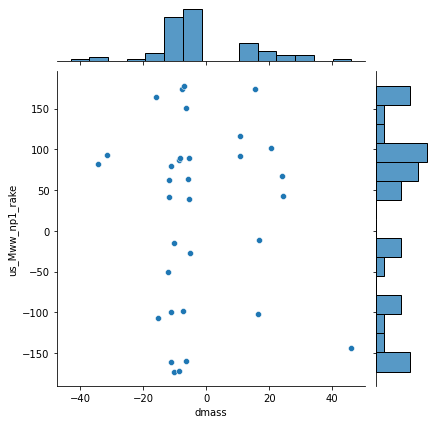

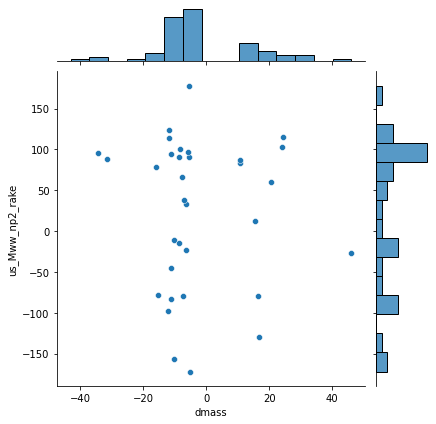

In [7]:
# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt
 
# Custom the inside plot: options are: “scatter” | “reg” | “resid” | “kde” | “hex”
ax=sns.jointplot(x=catalog.dmass, y=catalog.us_Mww_np1_rake, kind='scatter',marginal_kws=dict(bins=15, fill=True))
ax=sns.jointplot(x=catalog.dmass, y=catalog.us_Mww_np2_rake, kind='scatter',marginal_kws=dict(bins=15, fill=True))

plt.show()

## II. Correlation between surface load and dip angle

Text(0.5, 1.0, 'Correlation between surface load and dip angle')

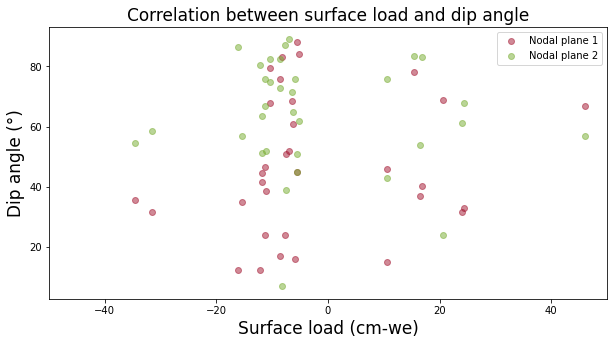

In [8]:
fig,ax = plt.subplots(figsize=(10,5))

plot1 = ax.scatter(catalog.dmass, catalog.us_Mww_np1_dip, alpha=0.5, c='#A2142F',label='Nodal plane 1')
plot2 = ax.scatter(catalog.dmass, catalog.us_Mww_np2_dip, alpha=0.5, c='#77AC30',label='Nodal plane 2')
ax.legend(handles=[plot1, plot2])
# ax.axhline(y=0,c='k')
# ax.axvline(x=0,c='k') 
ax.set_xlim([-50,50])
ax.set_xlabel('Surface load (cm-we)', fontsize = 17)
ax.set_ylabel("Dip angle (\N{DEGREE SIGN})", fontsize = 17)
ax.set_title("Correlation between surface load and dip angle", fontsize = 17)

### Angle = rake values
### Outside circle: + load
### Inside circle: - load

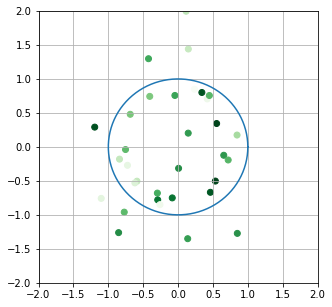

In [9]:
theta=catalog.us_Mww_np1_rake
R=1+(catalog.dmass/np.max(np.abs(catalog.dmass)))
theta2=np.linspace(0,2*np.pi,100)

fig, ax = plt.subplots(figsize=[5,5])
ax.scatter(R*np.cos(theta), R*np.sin(theta),c=catalog.us_Mww_np1_dip,cmap='Greens_r')
ax.plot(np.cos(theta2),np.sin(theta2))
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)
ax.grid()

# colored by dip

## III. Understanding the relationship between focal mechanisms and surface load using statistics:

### (a) F-test

In [10]:
from scipy.stats import f_oneway

f_oneway(catalog.dmass[catalog.us_Mww_np1_rake<0],catalog.dmass[catalog.us_Mww_np1_rake>0])
f_oneway(catalog.us_Mww_np1_rake[catalog.dmass<0],catalog.us_Mww_np1_rake[catalog.dmass>0])

F_onewayResult(statistic=nan, pvalue=nan)

In [11]:
sum(np.isnan(catalog.us_Mww_np1_rake))

46

### (b) Chi-squared test:

- Low value for the chi statistic: high correlation between your two sets of data. 
- P-value > [value], accept null hypothesis (no relationship between categorical variables; they are independent)
- In theory, if your observed and expected values were equal then the chi statistic would be 0

In [12]:
from scipy.stats import chi2_contingency

df = pd.DataFrame(np.array([['+ load', 6, 2], ['- load', 9, 8]]),
                   columns=['', '+ rake', '- rake'])

obs=np.array([[6,2],[9,8]])
df

,,+ rake,- rake
0,+ load,6,2
1,- load,9,8


In [13]:
chi2, p, dof, expected = chi2_contingency(obs)

print(f"chi2 statistic:     {chi2:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:")
print(expected)

chi2 statistic:     0.37531
p-value:            0.54013
degrees of freedom: 1
expected frequencies:
[[ 4.8  3.2]
 [10.2  6.8]]


## Analysis on correlation between slip and surface load

In [14]:
slip = np.sin(catalog.us_Mww_np1_rake)*np.sin(catalog.us_Mww_np1_dip)

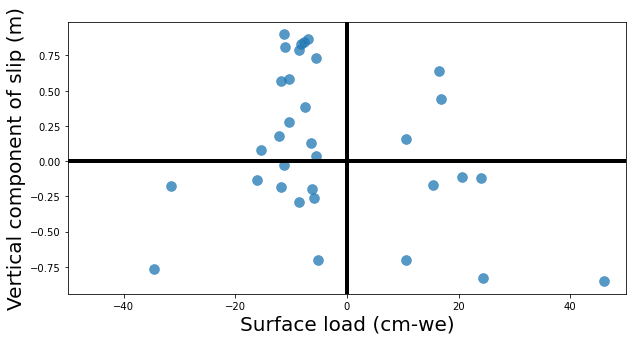

In [15]:
fig,ax = plt.subplots(figsize=(10,5))
plt.style.use('fivethirtyeight')

ax.axhline(y=0,c='k')
ax.axvline(x=0,c='k') 
plt.grid()
plot = ax.scatter(catalog.dmass, slip, alpha=0.75,s=100)
ax.set_xlim([-50,50])
ax.set_xlabel('Surface load (cm-we)', fontsize = 20)
ax.set_ylabel("Vertical component of slip (m)", fontsize = 20)
# ax.set_title("Correlation between surface load and slip", fontsize = 12)
ax.grid()

In [16]:
O11 = len(catalog.dmass[catalog.dmass<0][slip>0])
O12 = len(catalog.dmass[catalog.dmass>0][slip>0])
O21 = len(catalog.dmass[catalog.dmass<0][slip<0])
O22 = len(catalog.dmass[catalog.dmass>0][slip<0])

obs=np.array([[O11,O12],[O21,O22]])
print('contingency table:')
print(obs)
print()
chi2, p, dof, expected = chi2_contingency(obs)

print(f"chi2 statistic:     {chi2:.5g}")
print(f"p-value:            {p:.5g}")
print(f"degrees of freedom: {dof}")
print("expected frequencies:")
print(expected)

contingency table:
[[15  3]
 [ 9  6]]

chi2 statistic:     1.2235
p-value:            0.26868
degrees of freedom: 1
expected frequencies:
[[13.09090909  4.90909091]
 [10.90909091  4.09090909]]


In [17]:
O21

9

In [18]:
O22

6

In [19]:
(O22*O11 - O12*O21)/np.sqrt(O11*O12*O21*O22)

1.2780193008453875

In [20]:
(O11+O22)/(O11+O12+O21+O22)

0.6363636363636364

In [21]:
(O11+O12+O21+O22)

33

In [22]:
len(catalog)

79